Note: If some code appears to be cutoff please refer to the notebook version of this project

# Final Project

In this project we will analyze a multi-factor model by using some methods earlier in the course in order to simulate a typical buy-side quant research project.

## Import Packages

In [1]:
import pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pickle
from statsmodels.formula.api import ols
from scipy.stats import gaussian_kde
import scipy
import scipy.sparse
import patsy
from statistics import median
import bz2
import math
import os
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import statistics
import random

C:\Users\jesse\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Problem 1

In our first problem we will consider a list of potential alpha factors in order to combine all of these factors into a single, composite alpha factor. **The goal is to produce a composite alpha factor which does the best job of predicting the dependent varaible "Ret" on out-of-sample data**

We will restrict our training set on each day to a specific "estimation universe" in order to limit our analysis to a specifc set of stocks. Additionally, we will use cross-validation to select a model from the full family of models we are considering.

## Load Data

In general, parsing text into numbers, dates, and other python data types can be done once, at the beginning of a research project, and the results can be saved to binary files. If the files are more than a few megabytes, use compression to avoid filling up your disk. In the following example, the model data has already been pre-processed and saved into pickle files, and the bz2 compression algorithm was used.

In [2]:
model_dir = "C:/Users/jesse/Downloads/pandas_data/"

# sorts the columns of the dataframe alphabetically and returns the sorted
# dataframe
def sort_cols(test):
    return(test.reindex(sorted(test.columns), axis=1))

# Reads the pickle file using pd.read_pickle and
# updates the frames dictionary with the loaded dataframe
def load_frames(list_year):
    frames = {}
    for year in list_year:
        fil = model_dir + "pandas-frames." + str(year) + ".pickle.bz2"
        frames.update(pd.read_pickle( bz2.open( fil, "rb" ) ))

    # for each key the function sorts the columns of each dataframe stored
    # in the frames dictionary
    for x in frames:
        frames[x] = sort_cols(frames[x])

    return frames

We are taking the period 2005 as the ultimate test set which we will hold in "test_frames" until we are ready to do our final evaluation. Additionally, we will use the period 2004 for training/validation as the data was too large to process more data.

In [3]:
train_year = [2004]
train_frames = load_frames(train_year)

In [4]:
test_year = [2005]
test_frames = load_frames(test_year)

## Data Definitions

After the above loading operation is finished, "frames" will be a dictionary keyed by date. For example, the string "20040102" is one such key. Accessing the value at this key, with frames["20040102"], gives a data frame containing a daily cross section. Each row in the data frame corresponds to a particular stock, and there are many columns containing various attributes of the stock that have been collected. The meanings of the columns that we will use in this project are defined below; columns which may exist in the data, but not listed here, are not needed.

## Alpha factor selection

In a real trading scenario, alpha factor construction would be the culmination of a very long research process, usually undertaken by experts in financial markets and requiring time and ingenuity.
For this exercise, we consider several well-known alpha factors:

- 1DREVRSL: very short-term reversal, potential alpha factor but probably too fast-moving to be
tradable
- STREVRSL: short-term reversal, potential alpha factor
- EARNQLTY: earnings quality, potential alpha factor
- PROFIT: profitability, potential alpha factor

- MGMTQLTY: alpha factor which looks at quantitative measures of how well-run a company is by its management
- SEASON: seasonality-based alpha factor
- SENTMT: news sentiment alpha factor

## Style Factors

'BETA', 'SIZE', 'MOMENTUM', 'VALUE', 'GROWTH', 'LEVERAGE', 'LIQUIDTY',
                 'DIVYILD', 'LTREVRSL'

## Industry Factors

'AERODEF', 'AIRLINES', 'ALUMSTEL', 'APPAREL', 'AUTO',
       'BANKS','BEVTOB', 'BIOLIFE', 'BLDGPROD','CHEM', 'CNSTENG', 'CNSTMACH', 'CNSTMATL', 'COMMEQP', 'COMPELEC',
       'COMSVCS', 'CONGLOM', 'CONTAINR', 'DISTRIB',
       'DIVFIN', 'ELECEQP', 'ELECUTIL', 'FOODPROD', 'FOODRET', 'GASUTIL',
       'HLTHEQP', 'HLTHSVCS', 'HOMEBLDG', 'HOUSEDUR','INDMACH', 'INSURNCE', 'INTERNET',
        'LEISPROD', 'LEISSVCS', 'LIFEINS', 'MEDIA', 'MGDHLTH','MULTUTIL',
       'OILGSCON', 'OILGSDRL', 'OILGSEQP', 'OILGSEXP', 'PAPER', 'PHARMA',
       'PRECMTLS','PSNLPROD','REALEST',
       'RESTAUR', 'ROADRAIL','SEMICOND', 'SEMIEQP','SOFTWARE', 'SPLTYRET', 'SPTYCHEM', 'SPTYSTOR',
       'TELECOM', 'TRADECO', 'TRANSPRT', 'WIRELESS'

In [5]:
Potential_alphas = ["STREVRSL", "1DREVRSL", "EARNQLTY", "PROFIT"]
alpha = ["MGMTQLTY", "SEASON", "SENTMT"]

industry_factors = ['AERODEF', 'AIRLINES', 'ALUMSTEL', 'APPAREL', 'AUTO',
       'BANKS','BEVTOB', 'BIOLIFE', 'BLDGPROD','CHEM', 'CNSTENG', 
        'CNSTMACH', 'CNSTMATL', 'COMMEQP', 'COMPELEC',
       'COMSVCS', 'CONGLOM', 'CONTAINR', 'DISTRIB',
       'DIVFIN', 'ELECEQP', 'ELECUTIL', 'FOODPROD', 'FOODRET', 'GASUTIL',
       'HLTHEQP', 'HLTHSVCS', 'HOMEBLDG', 'HOUSEDUR','INDMACH', 
        'INSURNCE', 'INTERNET',
        'LEISPROD', 'LEISSVCS', 'LIFEINS', 'MEDIA', 'MGDHLTH','MULTUTIL',
       'OILGSCON', 'OILGSDRL', 'OILGSEQP', 'OILGSEXP', 'PAPER', 'PHARMA',
       'PRECMTLS','PSNLPROD','REALEST',
       'RESTAUR', 'ROADRAIL','SEMICOND', 'SEMIEQP','SOFTWARE', 'SPLTYRET',
        'SPTYCHEM', 'SPTYSTOR',
       'TELECOM', 'TRADECO', 'TRANSPRT', 'WIRELESS']

style_factors = ['BETA', 'SIZE', 'MOMENTUM', 'VALUE', 'GROWTH', 'LEVERAGE', 
                 'LIQUIDTY',
                 'DIVYILD', 'LTREVRSL']

## Data Cleaning and Winsorization

The distribution of many statistics can be heavily influenced by outliers. A simple approach to robustifying parameter estimation procedures is to set all outliers to a specified percentile of the data; for example, a 90% winsorization would see all data below the 5th percentile set to the 5th percentile, and data above the 95th percentile set to the 95th percentile. Winsorized estimators are usually more robust to outliers than their more standard forms.

In [6]:
def wins(x,a,b):
    return(np.where(x <= a,a, np.where(x >= b, b, x)))

# Factors

## Factor Exposures and Factor Returns


Arbitrage pricing theory relaxes several of the assumptions made in the course of deriving
the CAPM. In particular, we relax the assumption that all investors do the same optimization
and hence that there is a single efficient fund. This allows the possibility that a CAPM-like
relation may hold, but with multiple underlying sources of risk.

Specifically, let $r_i, i = 1, \ldots, n$ denote the cross-section of asset returns over a given
time period $[t, t+1]$. In a fully-general model, the multivariate distribution $p(\mathbf{r})$ could have
arbitrary covariance and higher-moment structures, but remember that for $n$ large there is
typically never enough data to estimate such over-parameterized models.

Instead, we assume a
structural model which is the most direct generalization of the CAPM:
$$
	r_i = \beta_{i, 1} f_1 + \beta_{i,2} f_2 + \dots + \beta_{i, p} f_p + \epsilon_i, \quad
	\epsilon_i \sim N(0, \sigma_i^2)  
$$
If $p = 1$, this reduces to the Capital Asset Pricing Model (CAPM) in a rather direct way.

With $p > 1$, the model starts to differ from the CAPM
in several very important aspects. In the CAPM, we were
able to identify the single efficient fund by arguing that its weights must equal the
market-capitalization weights. Hence we were given for free a very nice proxy for the
single efficient fund: a capitalization-weighted basket such as the Russell 3000.
Hence in the $p=1$ case we had a convenient proxy which could be used to impute
the return $f_1$, which we called $r_M$. Also $\beta_{i, 1}$ could be estimated, with
no more than the usual statistical estimation error, by time-series regression.

If $p > 1$ then the underlying assumptions of that argument break down: there is no
longer any simple way to identify $f_{j}$ nor $\beta_{i, j}$ ($j = 1, \ldots, p$).
We shall return to the estimation problem in due course.


To avoid confusion with the CAPM, and its simplistic $\beta$ coefficient (which is still
sometimes used in larger multi-factor models), it is conventional to make the following
notation change: $\beta_{i,j}$ becomes $X_{i,j}$ and so the model equation becomes
$$
	 	r_i = X_{i, 1} f_1 + X_{i,2} f_2 + \dots + X_{i, p} f_p + \epsilon_i, \quad
	\epsilon_i \sim N(0, \sigma_i^2)  
$$
It's difficult to simultaneously estimate both all components $X_{i,j}$ and all risk-source
returns $f_j$, so one usually assumes one is known and calculates the other via regression.
In what follows, we focus on the approach where $X$ is known, and the $f_j$ are assumed
to be hidden (aka latent) variables.

The structural equation is more conveniently expressed in matrix form:
$$
	R_{t+1} = X_t f_{t+1} + \epsilon_{t+1}, \quad E[\epsilon] = 0, \ \ V[\epsilon] = D
$$
where $R_{t+1}$ is an $n$-dimensional random vector containing the
cross-section of returns in excess of the risk-free rate over some
time interval $[t, t+1]$, and $X_t$ is a (non-random) $n \times p$ matrix
that can be calculated entirely from data known before time $t$.
The variable $f$ in denotes a $p$-dimensional random vector
process which cannot be observed directly.

Since the variable $f$ denotes a $p$-dimensional random vector process which cannot
be observed directly, information about the $f$-process must be obtained via statistical inference.
We assume that the $f$-process has finite first and second moments given by
$$
	E[f] = \mu_f, \ \text{ and } \  V[f] = F .
$$
The primary outputs of a statistical inference process are the parameters
$\mu_f$ and $F$, and other outputs one might be interested in
include estimates of the daily realizations $\hat{f}_{t+1}$.

The simplest way of estimating historical daily realizations of $\hat{f}_{t+1}$ is by least-squares (ordinary or weighted, as appropriate), viewing the defining
model equation as a regression problem.

In [7]:
## an R-style formula which can be used to construct a cross sectional 
# regression
def get_formula(alphas, Y):

    L = ["0"]
    L.extend(alphas)
    L.extend(style_factors)
    L.extend(industry_factors)
    return Y + " ~ " + " + ".join(L)

## The term 'estu' is short for estimation universe
def get_estu(df):

    # Rename '1DREVRSL to DREVRSL'
    df.rename(columns={'1DREVRSL': 'DREVRSL'}, inplace=True)

    # Filtering the dataframe to get the estimation universe where the 
    # IssuerMarketCap is greater than 1e9
    estu = df.loc[df.IssuerMarketCap > 1e9].copy(deep=True)

    return estu

def estimate_factor_returns(df, alphas):

    ## build universe based on filters
    estu = get_estu(df)

    ## winsorize returns for fitting
    estu['Ret'] = wins(estu['Ret'], -0.25, 0.25)

    ## Fit Ordinary Least Squares (OLS) regression model using the 
    # constructed formula
    model = ols(get_formula(alphas, "Ret"), data=estu)

    return(model.fit())

## Getting Factor Returns
Running one OLS per day over several years, where each OLS involves several thousand observations and about 50-100 independent variables, takes a few minutes.

In [8]:
def get_factor_return(frames, alpha, plot_fr = True):
    facret = {}

    for date in frames:
        facret[date] = estimate_factor_returns(frames[date], list(alpha)).params

    print("Factor Returns Computed!")

    return facret

alpha = ["MGMTQLTY", "SEASON", "SENTMT", "STREVRSL", "EARNQLTY", "PROFIT"]
facret_alpha  = get_factor_return(train_frames, alpha)

Factor Returns Computed!


## Plotting the Cumulative Sum of Alpha Factor Returns

We now have a multivariate time series of factor returns stored in the variable facret. We can plot the cumulative sum of the factor returns.

<AxesSubplot:>

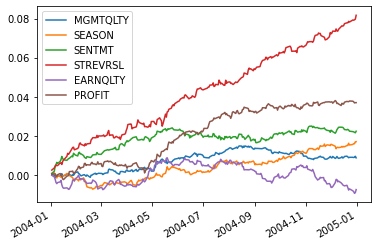

In [9]:
# Convert the keys of train_frames to datetime objects, sort them, 
# and store in my_dates
my_dates = sorted(list(map(lambda date: pd.to_datetime(date, format='%Y%m%d'), train_frames.keys())))

# Create an empty dataframe with index as my_dates
facret_df = pd.DataFrame(index = my_dates)

# For each date and each alpha factor
for dt in my_dates:
    for alp in alpha:

        # Retrieve the factor returns for each alpha factor at the 
        # current date and assign it to facret_df
        facret_df.at[dt, alp] = facret_alpha[dt.strftime('%Y%m%d')][alp]

# Plot the cumulative sum of factor returns over time
facret_df.cumsum().plot()

## Plotting the Cumulative Sum of Industry Factor Returns

<AxesSubplot:>

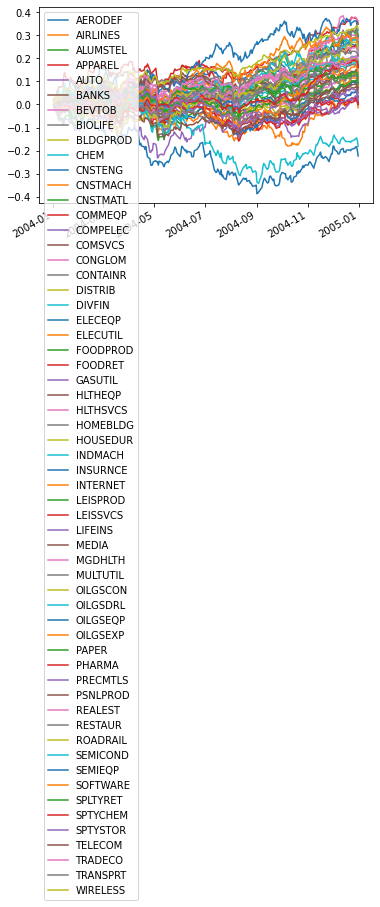

In [10]:
my_dates = sorted(list(map(lambda date: pd.to_datetime(date, format='%Y%m%d'), train_frames.keys())))

facret_df_inds = pd.DataFrame(index = my_dates)

for dt in my_dates:
    for alp in industry_factors:

        facret_df_inds.at[dt, alp] = facret_alpha[dt.strftime('%Y%m%d')][alp]

facret_df_inds.cumsum().plot()

## Plotting the Cumulative Sum of Style Factor Returns

<AxesSubplot:>

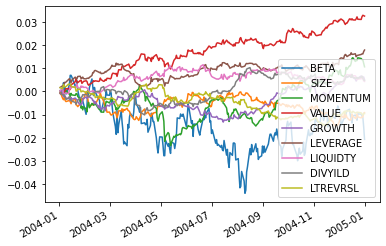

In [11]:
my_dates = sorted(list(map(lambda date: pd.to_datetime(date, format='%Y%m%d'), train_frames.keys())))

facret_df_style = pd.DataFrame(index = my_dates)

for dt in my_dates:
    for alp in style_factors:

        facret_df_style.at[dt, alp] = facret_alpha[dt.strftime('%Y%m%d')][alp]

facret_df_style.cumsum().plot()

## Plotting the Compositve Alpha, Style, and Industry Factors
The following table gives the vector called $\mu_{f}$ in lecture.

In [12]:
# Calculate the composite alpha, style, and industry factors

# Append to Dictionary
mean_dict = {}

# Alpha
mean_alpha_factor_returns = facret_df.mean().to_dict()

print("Mean Alpha Factor Returns")
for x,y in mean_alpha_factor_returns.items():
    print(x,y)
    mean_dict[x] = y
print()

# Industry
mean_industry_factor_returns = facret_df_inds.mean().to_dict()

print("Mean Industry Factor Returns")
for x,y in mean_industry_factor_returns.items():
    print(x,y)
    mean_dict[x] = y
print()

# Style
mean_style_factor_returns = facret_df_style.mean().to_dict()

print("Mean Style Factor Returns")
for x,y in mean_style_factor_returns.items():
    print(x,y)
    mean_dict[x] = y
print()



Mean Alpha Factor Returns
MGMTQLTY 3.479344956230722e-05
SEASON 6.766508145261472e-05
SENTMT 8.887079390379914e-05
STREVRSL 0.0003240677336834181
EARNQLTY -2.952057761864898e-05
PROFIT 0.00014679156078909348

Mean Industry Factor Returns
AERODEF 0.0008364039411300671
AIRLINES -5.7479795315431605e-05
ALUMSTEL 0.0010829949511445506
APPAREL 0.0009490142220318771
AUTO 3.135908920581122e-06
BANKS 0.0006927373628530731
BEVTOB 0.0007477900287964933
BIOLIFE 0.0002858834029196831
BLDGPROD 0.00044723209617640656
CHEM 0.0011775948222931345
CNSTENG 0.00100429066279409
CNSTMACH 0.0011280126066861714
CNSTMATL 0.0011733269101633255
COMMEQP 1.9612561098231954e-06
COMPELEC 0.00012072871778201336
COMSVCS 0.00029590320481969053
CONGLOM 0.001095831796559359
CONTAINR 0.0010462027615010688
DISTRIB 0.00047311006739893556
DIVFIN 0.0006399421441521586
ELECEQP 0.00012829884859298524
ELECUTIL 0.0006626160497175134
FOODPROD 0.0007442026110796972
FOODRET 3.3984626756409676e-05
GASUTIL 0.0004387892981398746
HLTHEQP

## Testing

As stated before, the simplest way of estimating historical daily realizations of $\hat{f}_{t+1}$ is by least-squares (ordinary or weighted, as appropriate), viewing the defining model equation as a regression problem.

The MAE is a metric which measures the average absolute difference between the predicted and actual returns. The Mean Absolute Error (MAE) can be used to determine which model is the most effective by examing which model has the lowest MAE. It can be seen below that a standard OLS deliveres the lowest MAE and is, therefore, the best preforming model out of the others tested.

First we will examine the cumulative sum of the alpha factor returns and the potential alpha factor returns seperatley:

In [13]:
def split_dict(data, train_frac=0.7):
    random.seed(42)

    keys = list(data.keys())
    random.shuffle(keys)
    split_idx = int(math.ceil(len(keys) * train_frac))

    train_dict = {key: data[key] for key in keys[:split_idx]}
    validation_dict = {key: data[key] for key in keys[split_idx:]}

    return train_dict, validation_dict


train_year = [2004]
train_frames = load_frames(train_year)
train_data, val_data = split_dict(train_frames, train_frac=0.8)

In [14]:
def wins(x,a,b):
    return(np.where(x <= a,a, np.where(x >= b, b, x)))

## an R-style formula which can be used to construct a cross sectional 
# regression
def get_formula(alphas, Y):
    L = ["0"]
    L.extend(alphas)
    L.extend(style_factors)
    L.extend(industry_factors)
    return Y + " ~ " + " + ".join(L)

## The term 'estu' is short for estimation universe
def get_estu(df):
    df.rename(columns={'1DREVRSL': 'DREVRSL'}, inplace=True)
    estu = df.loc[df.IssuerMarketCap > 1e9].copy(deep=True)
    return estu

def estimate_factor_returns(df, alphas):
    ## build universe based on filters
    estu = get_estu(df)

    ## winsorize returns for fitting
    estu['Ret'] = wins(estu['Ret'], -0.25, 0.25)

    model = ols(get_formula(alphas, "Ret"), data=estu)
    return(model.fit())

def get_factor_return(frames, alpha, plot_fr = True):
    facret = {}

    for date in frames:
        facret[date] = estimate_factor_returns(frames[date], list(alpha)).params

    print("Factor Returns Computed!")

    my_dates = sorted(list(map(lambda date: pd.to_datetime(date, format='%Y%m%d'), frames.keys())))
    facret_df = pd.DataFrame(index = my_dates)

    for dt in my_dates:
        for alp in alpha:
            facret_df.at[dt, alp] = facret[dt.strftime('%Y%m%d')][alp]

    if plot_fr == True:
        facret_df.cumsum().plot()

    mean_factor_returns = facret_df.mean().to_dict()

    return mean_factor_returns

#### Alpha Factor Returns

Factor Returns Computed!
{'MGMTQLTY': 2.3901876275616044e-05, 'SEASON': 5.689940799398483e-05, 'SENTMT': 3.779221848451474e-05}


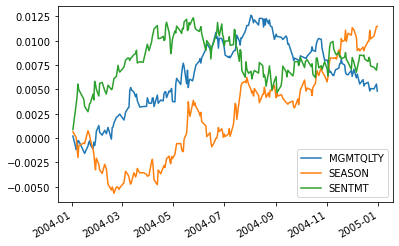

In [15]:
alpha = ["MGMTQLTY", "SEASON", "SENTMT"]
mean_fr_alpha  = get_factor_return(train_data, alpha)
print(mean_fr_alpha)

#### Potential Alpha Factor Returns 

Factor Returns Computed!
{'STREVRSL': 0.0003389824148310568, 'DREVRSL': 0.000388048898699251, 'EARNQLTY': 9.457807978996429e-06, 'PROFIT': 0.0001759264491665784}


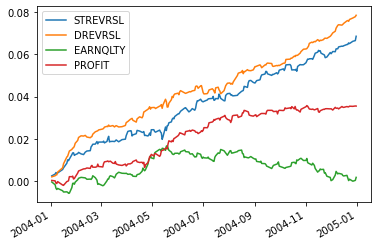

In [16]:
Potential_alphas = ['STREVRSL', 'DREVRSL', 'EARNQLTY', 'PROFIT']
mean_fr_pot_alpha  = get_factor_return(train_data, Potential_alphas)
print(mean_fr_pot_alpha)

#### OLS

We, first, examine the preformance of two types of OLS models:
- OLS with Alpha Factors
- OLS with Alpha Factors with Polynomial Factors

Thier preformance will be gauged and measured via the MAE metric

#### OLS with Alpha Factors

In [17]:
alpha_factors = ["MGMTQLTY", "SEASON", "SENTMT",  "STREVRSL", "EARNQLTY", "PROFIT"]

##### Examining the Cumulative Factor Returns

In [18]:
def estimate_factor_returns_1(df, alphas):
    ## build universe based on filters
    estu = get_estu(df)

    ## winsorize returns for fitting
    estu['Ret'] = wins(estu['Ret'], -0.25, 0.25)

    X = estu[alphas].values.astype('float32')
    Y = estu['Ret'].values.astype('float32')

    model = sm.OLS(Y, X)
    return (model.fit())

In [19]:
def get_factor_return(frames, alpha, estimate_factor_returns, plot_fr=True):
    facret = {}

    for date in frames:
        results = estimate_factor_returns(frames[date], alpha)
        if results is not None:
            # Create a dictionary from alpha names and coefficients
            facret[date] = dict(zip(alpha, results.params))

    print("Factor Returns Computed!")

    # Prepare DataFrame
    my_dates = sorted(pd.to_datetime(date, format='%Y%m%d') for date in frames.keys())
    facret_df = pd.DataFrame(index=my_dates)

    # Populate DataFrame
    for dt in my_dates:
        formatted_date = dt.strftime('%Y%m%d')
        if formatted_date in facret:
            for alp in alpha:
                if alp in facret[formatted_date]:
                    facret_df.at[dt, alp] = facret[formatted_date][alp]

    # Plotting
    if plot_fr and not facret_df.empty:
        facret_df.cumsum().plot()

    # Compute and return mean factor returns
    mean_factor_returns = facret_df.mean().to_dict()

    return mean_factor_returns

Factor Returns Computed!


{'MGMTQLTY': -2.7885677926599665e-06,
 'SEASON': 5.146734333540717e-05,
 'SENTMT': -0.00011312273103486756,
 'STREVRSL': 0.0003270803417819371,
 'EARNQLTY': -2.2152118456706196e-05,
 'PROFIT': -4.600966213045035e-05}

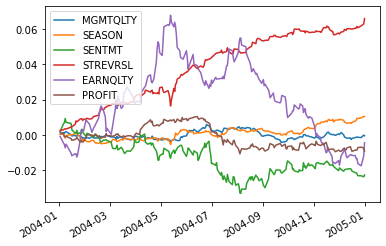

In [20]:
mean_factor_return_1 = get_factor_return(train_data, alpha_factors, estimate_factor_returns_1, plot_fr=True)
mean_factor_return_1

##### Computing the MAE 

In [21]:
def compute_mae(val_data, mean_fr_alpha):
    mae = {}
    for date, df in val_data.items():

        predicted_returns = df[list(mean_fr_alpha.keys())].dot(pd.Series(mean_fr_alpha))

        # Compute the MSE for this date
        mae[date] = (predicted_returns - df['Ret']).abs().mean()

    return mae

In [22]:
mae_1 = compute_mae(val_data, mean_factor_return_1)
statistics.mean(mae_1.values())

0.10752547681439226

#### Polynomial Factors

##### Examining Cumulative Factor Returns 

In [23]:
from itertools import combinations_with_replacement
from sklearn.preprocessing import PolynomialFeatures

In [24]:
def polynomial_feature_names(features, degree):
    def iter_terms():
        terms = []
        for total_degree in range(1, degree + 1):
            for items in combinations_with_replacement(features, total_degree):
                terms.append("*".join(sorted(items)))
        return terms

    return iter_terms()


def estimate_factor_returns_2(df, alphas):
    ## Build universe based on filters
    estu = get_estu(df)

    ## Winsorize returns for fitting
    estu['Ret'] = wins(estu['Ret'], -0.25, 0.25)

    # Create polynomial features for alphas
    # Degree 2 for interactions and squared terms
    poly = PolynomialFeatures(degree=2, include_bias=False)  
    alpha_poly = poly.fit_transform(estu[alphas])

    # Generate feature names manually
    feature_names = polynomial_feature_names(alphas, degree=2)

    # Create a DataFrame with the polynomial features 
    # and assign the new names
    alpha_poly_df = pd.DataFrame(alpha_poly, index=estu.index, columns=feature_names)

    # Ensure we include the response variable in our new DataFrame
    enhanced_df = pd.concat([alpha_poly_df, estu['Ret']], axis=1)

    X = enhanced_df.drop('Ret', axis=1).values.astype('float32')
    Y = enhanced_df['Ret'].values.astype('float32')

    model = sm.OLS(Y, X)
    return (model.fit()), feature_names

In [25]:
def get_factor_return_2(frames, alpha, plot_fr=True):
    facret = {}

    for date in frames:
        results, alpha_new = estimate_factor_returns_2(frames[date], alpha)
        # print(alpha_new)
        if results is not None:
            # Create a dictionary from alpha names and coefficients
            facret[date] = dict(zip(alpha_new, results.params))

    print("Factor Returns Computed!")

    # Prepare DataFrame
    my_dates = sorted(pd.to_datetime(date, format='%Y%m%d') for date in frames.keys())
    facret_df = pd.DataFrame(index=my_dates)

    # Populate DataFrame
    for dt in my_dates:
        formatted_date = dt.strftime('%Y%m%d')
        if formatted_date in facret:
            for alp in alpha_new:
                if alp in facret[formatted_date]:
                    facret_df.at[dt, alp] = facret[formatted_date][alp]

    # Plotting
    if plot_fr and not facret_df.empty:
        facret_df.cumsum().plot()

    # Compute and return mean factor returns
    mean_factor_returns = facret_df.mean().to_dict()

    return mean_factor_returns

Factor Returns Computed!


{'MGMTQLTY': -3.3826504522498862e-06,
 'SEASON': 4.231001761725944e-05,
 'SENTMT': 5.288376037512562e-05,
 'STREVRSL': 0.0003415770789938686,
 'EARNQLTY': 0.00017832669320143557,
 'PROFIT': -0.00018451574203144186,
 'MGMTQLTY*MGMTQLTY': 2.6184649589658243e-05,
 'MGMTQLTY*SEASON': -9.165974818706043e-05,
 'MGMTQLTY*SENTMT': -7.649359059769267e-05,
 'MGMTQLTY*STREVRSL': -3.6278235229744524e-05,
 'EARNQLTY*MGMTQLTY': -4.9030976571326514e-05,
 'MGMTQLTY*PROFIT': 5.986620596270921e-06,
 'SEASON*SEASON': -3.078182664178865e-05,
 'SEASON*SENTMT': 2.2014640249511617e-05,
 'SEASON*STREVRSL': 3.179827656525292e-05,
 'EARNQLTY*SEASON': 6.600208600878765e-05,
 'PROFIT*SEASON': 8.381245021073167e-05,
 'SENTMT*SENTMT': -0.00012650615561970782,
 'SENTMT*STREVRSL': -6.444239282488822e-05,
 'EARNQLTY*SENTMT': 9.697076707243018e-05,
 'PROFIT*SENTMT': -1.4958182486459396e-05,
 'STREVRSL*STREVRSL': 3.792777728548491e-05,
 'EARNQLTY*STREVRSL': 8.55013202297387e-06,
 'PROFIT*STREVRSL': 5.432253971938024e-05

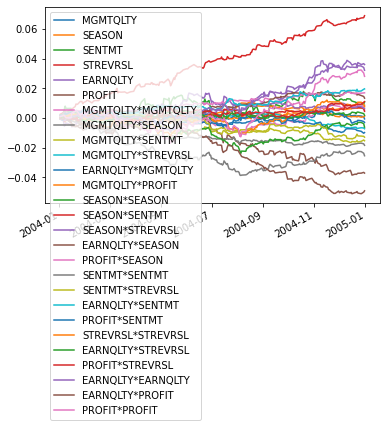

In [26]:
mean_factor_return_2 = get_factor_return_2(train_data, alpha_factors, plot_fr=True)
mean_factor_return_2

##### Computing the MAE

In [27]:
def polynomial_feature_names(features, degree):
    terms = []
    for total_degree in range(1, degree + 1):
        for items in combinations_with_replacement(features, total_degree):
            terms.append("*".join(sorted(items)))
    return terms

# Now let's fix the add_polynomial_features function
def add_polynomial_features(df, alphas):
    # Create polynomial features
    poly = PolynomialFeatures(degree=2, include_bias=False)
    alpha_poly = poly.fit_transform(df[alphas])

    # Use the custom function to generate feature names
    feature_names = polynomial_feature_names(alphas, degree=2)
    poly_df = pd.DataFrame(alpha_poly, index=df.index, columns=feature_names)

    # Return the DataFrame with additional polynomial features
    return poly_df

def compute_mae(val_data, mean_fr_alpha, alpha_factors):
    mae = {}
    # List of all original and polynomial factor names
    alphas = list(mean_fr_alpha.keys())  

    for date, df in val_data.items():
        # Add polynomial features to the DataFrame
        df_with_poly = add_polynomial_features(df, alpha_factors)

        predicted_returns = df_with_poly[alphas].dot(pd.Series(mean_fr_alpha))

        # Compute the MAE for this date
        mae[date] = (predicted_returns - df['Ret']).abs().mean()

    return mae

In [28]:
mae_2 = compute_mae(val_data, mean_factor_return_2, alpha_factors)
statistics.mean(mae_2.values())

0.10763664785994159

### Ridge Regression

Next we try Ridge Regression for two cases:
- The first case is with only the alpha factors
- The second case is with all the alpha factors

In [29]:
from sklearn.linear_model import Ridge

In [30]:
## Winsorization
def wins(x,a,b):
    return(np.where(x <= a,a, np.where(x >= b, b, x)))

## The term 'estu' is short for estimation universe
def get_estu(df):
    df.rename(columns={'1DREVRSL': 'DREVRSL'}, inplace=True)
    estu = df.loc[df.IssuerMarketCap > 1e9].copy(deep=True)
    return estu

In [31]:
def estimate_factor_returns_ridge(df, alphas):
    # Build universe based on filters
    estu = get_estu(df)

    # Winsorize returns for fitting
    estu['Ret'] = wins(estu['Ret'], -0.25, 0.25)

    X = estu[alphas].values.astype('float32')
    Y = estu['Ret'].values.astype('float32')

    # Initialize Ridge Regression model
    # alpha parameter controls the strength of regularization
    # Larger alpha => stronger regularization
    ridge_model = Ridge(alpha=1.5)

    # Fit the model
    return (ridge_model.fit(X, Y))

In [32]:
def get_factor_return_ridge(frames, alpha, plot_fr=True):
    facret = {}

    for date in frames:
        results = estimate_factor_returns_ridge(frames[date], alpha).coef_
        if results is not None:
            # Create a dictionary from alpha names and coefficients
            facret[date] = dict(zip(alpha, results))

    print("Factor Returns Computed!")

    # Prepare DataFrame
    my_dates = sorted(pd.to_datetime(date, format='%Y%m%d') for date in frames.keys())
    facret_df = pd.DataFrame(index=my_dates)

    # Populate DataFrame
    for dt in my_dates:
        formatted_date = dt.strftime('%Y%m%d')
        if formatted_date in facret:
            for alp in alpha:
                if alp in facret[formatted_date]:
                    facret_df.at[dt, alp] = facret[formatted_date][alp]

    # Plotting
    if plot_fr and not facret_df.empty:
        facret_df.cumsum().plot()

    # Compute and return mean factor returns
    mean_factor_returns = facret_df.mean().to_dict()

    return mean_factor_returns

#### Alpha ONLY

Factor Returns Computed!


{'MGMTQLTY': -3.4651658932777384e-06,
 'SEASON': 1.3335875176398806e-05,
 'SENTMT': -0.00012883717387228557,
 'STREVRSL': 0.00033600600436960187,
 'EARNQLTY': 3.535912559761915e-05,
 'PROFIT': -2.5949985787393767e-05}

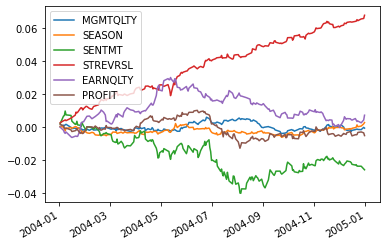

In [33]:
mean_factor_return_ridge = get_factor_return_ridge(train_data, alpha_factors, plot_fr=True)
mean_factor_return_ridge

In [34]:
def compute_mae(val_data, mean_fr_alpha):
    mae = {}
    for date, df in val_data.items():

        predicted_returns = df[list(mean_fr_alpha.keys())].dot(pd.Series(mean_fr_alpha))
        mae[date] = (predicted_returns - df['Ret']).abs().mean()

    return mae

In [35]:
mae_ridge = compute_mae(val_data, mean_factor_return_ridge)
statistics.mean(mae_ridge.values())

0.10752445337011628

#### All Factors

Factor Returns Computed!


{'AERODEF': 0.00027943152259233623,
 'AIRLINES': -0.0003654242463838246,
 'ALUMSTEL': 0.0006250086576929419,
 'APPAREL': 0.00013623395165322476,
 'AUTO': -0.0003626905982216185,
 'BANKS': 0.00012540709595479783,
 'BEVTOB': 0.00034998536692919425,
 'BIOLIFE': -0.00015635926010332642,
 'BLDGPROD': 4.2310736383718325e-06,
 'CHEM': 0.0006863072572485018,
 'CNSTENG': 0.0001927367452255999,
 'CNSTMACH': 0.0006816279807962658,
 'CNSTMATL': 0.0006116385566404253,
 'COMMEQP': -0.000492529192090635,
 'COMPELEC': -0.0003487346897204003,
 'COMSVCS': -0.00010696730848871769,
 'CONGLOM': 0.00072023538058881,
 'CONTAINR': 0.0005112930802899409,
 'DISTRIB': -0.00016785601712741697,
 'DIVFIN': 7.325212118753415e-05,
 'ELECEQP': -0.0005436977597596389,
 'ELECUTIL': 6.175300928355295e-05,
 'FOODPROD': 0.00031515374657918995,
 'FOODRET': -0.0003503239207173753,
 'GASUTIL': 3.739668925458552e-05,
 'HLTHEQP': 0.00015885897071729962,
 'HLTHSVCS': -0.0001119243062732656,
 'HOMEBLDG': 0.00024227619428754702,
 

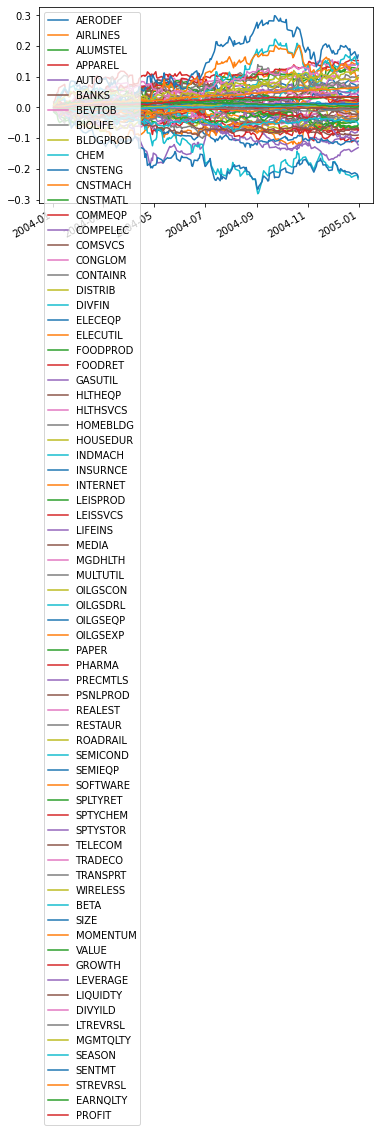

In [36]:
all_factors = industry_factors + style_factors + alpha_factors
mean_factor_return_ridge = get_factor_return_ridge(train_data, all_factors, plot_fr=True)
mean_factor_return_ridge

In [37]:
def compute_mae(val_data, mean_fr_alpha):
    mae = {}
    for date, df in val_data.items():

        predicted_returns = df[list(mean_fr_alpha.keys())].dot(pd.Series(mean_fr_alpha))
        mae[date] = (predicted_returns - df['Ret']).abs().mean()

    return mae

In [38]:
mae_ridge = compute_mae(val_data, mean_factor_return_ridge)
statistics.mean(mae_ridge.values())

0.10760574684673949

### Model Elastic
Next, we try an ElasticNet model

In [39]:
from sklearn.linear_model import ElasticNet

In [40]:
## Winsorization
def wins(x,a,b):
    return(np.where(x <= a,a, np.where(x >= b, b, x)))

## The term 'estu' is short for estimation universe
def get_estu(df):
    estu = df.loc[df.IssuerMarketCap > 1e9].copy(deep=True)
    return estu

In [41]:
def estimate_factor_returns_elasticnet(df, alphas):
    estu = get_estu(df)
    estu['Ret'] = wins(estu['Ret'], -0.25, 0.25)

    X = estu[alphas].values.astype('float32')
    Y = estu['Ret'].values.astype('float32')

    elastic_net_model = ElasticNet(alpha=0.1, l1_ratio=0.5)

    return (elastic_net_model.fit(X, Y))

In [42]:
def get_factor_return_ridge(frames, alpha, plot_fr=True):
    facret = {}

    for date in frames:
        results = estimate_factor_returns_elasticnet(frames[date], alpha).coef_
        if results is not None:
            # Create a dictionary from alpha names and coefficients
            facret[date] = dict(zip(alpha, results))

    print("Factor Returns Computed!")

    # Prepare DataFrame
    my_dates = sorted(pd.to_datetime(date, format='%Y%m%d') for date in frames.keys())
    facret_df = pd.DataFrame(index=my_dates)

    # Populate DataFrame
    for dt in my_dates:
        formatted_date = dt.strftime('%Y%m%d')
        if formatted_date in facret:
            for alp in alpha:
                if alp in facret[formatted_date]:
                    facret_df.at[dt, alp] = facret[formatted_date][alp]

    # Plotting
    if plot_fr and not facret_df.empty:
        facret_df.cumsum().plot()

    # Compute and return mean factor returns
    mean_factor_returns = facret_df.mean().to_dict()

    return mean_factor_returns

Factor Returns Computed!


{'MGMTQLTY': 0.0,
 'SEASON': 0.0,
 'SENTMT': 0.0,
 'STREVRSL': 0.0,
 'EARNQLTY': 0.0,
 'PROFIT': 0.0}

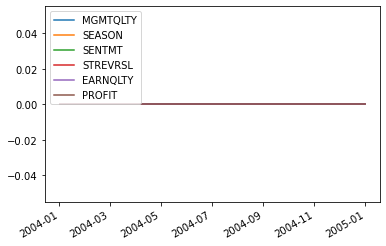

In [43]:
mean_factor_return_elastic = get_factor_return_ridge(train_data, alpha_factors, plot_fr=True)
mean_factor_return_elastic

In [44]:
def compute_mae(val_data, mean_fr_alpha):
    mae = {}
    for date, df in val_data.items():

        predicted_returns = df[list(mean_fr_alpha.keys())].dot(pd.Series(mean_fr_alpha))
        mae[date] = (predicted_returns - df['Ret']).abs().mean()

    return mae

In [45]:
mae_elastic = compute_mae(val_data, mean_factor_return_elastic)
statistics.mean(mae_elastic.values())

0.10734778213913958

Finally, we conduct an OLS regression where we break up the alpha factors into two groups
- Alpha (semi): We can consider and OLS regression with only certain Alpha factors
- Alpha (pot): We can consider an OLS regression with only potential Alpha factors 

In [46]:
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

In [47]:
def compute_test_returns(test_frames, mean_fr_alpha):
    mae = {}
    for date, df in test_frames.items():

        # Compute the predicted returns 
        # for the date using the dot product
        df.rename(columns={'1DREVRSL': 'DREVRSL'}, inplace=True)
        predicted_returns = df[list(mean_fr_alpha.keys())].dot(pd.Series(mean_fr_alpha))

        # Compute the MSE for this date
        mae[date] = (predicted_returns - df['Ret']).abs().mean()

    return mae

In [48]:
mae_results_alpha = compute_test_returns(val_data, mean_fr_alpha)
mae_results_pot_alpha = compute_test_returns(val_data, mean_fr_pot_alpha)

In [49]:
from datetime import datetime

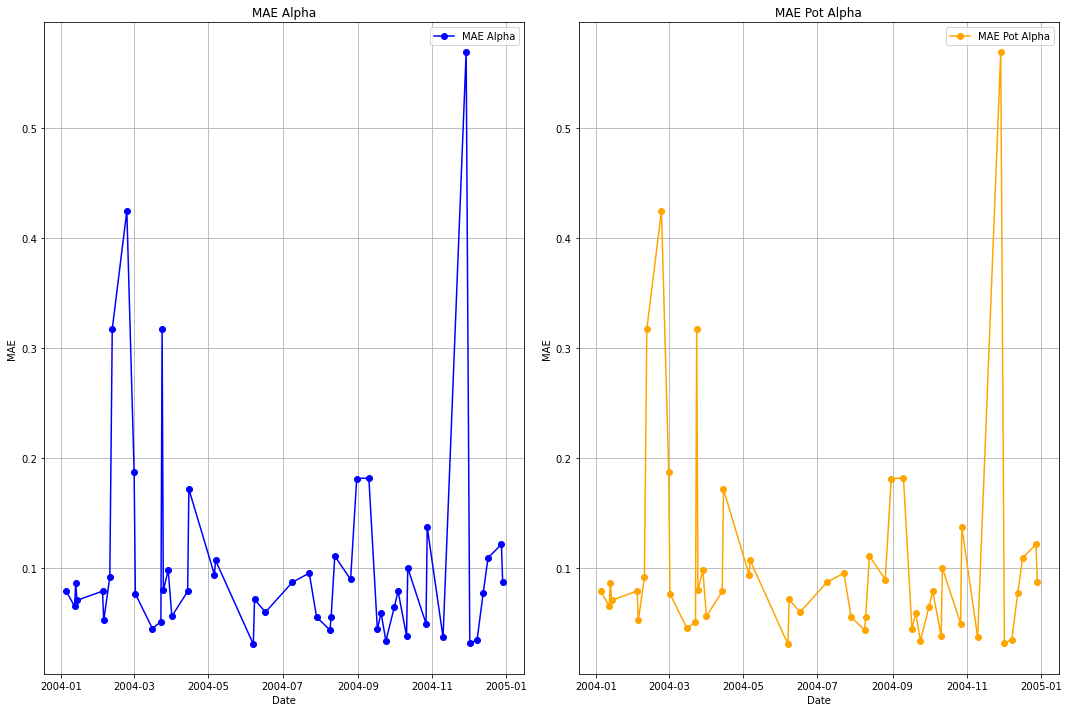

In [50]:
# Sorting and preparing dates
dates = sorted(set(val_data.keys()))
errors_alpha = [mae_results_alpha[date] for date in dates]
errors_pot_alpha = [mae_results_pot_alpha[date] for date in dates]
dates = [datetime.strptime(date, '%Y%m%d') for date in dates]

# Creating subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 10), sharex=True)

# Plotting each subplot
axs[0].plot(dates, errors_alpha, label='MAE Alpha', marker='o', color='blue')
axs[0].set_title('MAE Alpha')
axs[0].grid(True)

axs[1].plot(dates, errors_pot_alpha, label='MAE Pot Alpha', marker='o', color='orange')
axs[1].set_title('MAE Pot Alpha')
axs[1].grid(True)

# Setting up the x-axis label
for ax in axs.flat:
    ax.set(xlabel='Date', ylabel='MAE')
    ax.legend()

# Adjust the layout to make room for all subplot titles and labels
plt.tight_layout()  
plt.show()

In [51]:
import statistics

In [52]:
print("Mean Absolute Error for different model")
print("Alpha OLS:" , statistics.mean(mae_results_alpha.values()))
print("Pot Alpha OLS:" , statistics.mean(mae_results_pot_alpha.values()))

Mean Absolute Error for different model
Alpha OLS: 0.10738807995741469
Pot Alpha OLS: 0.1075654070139742


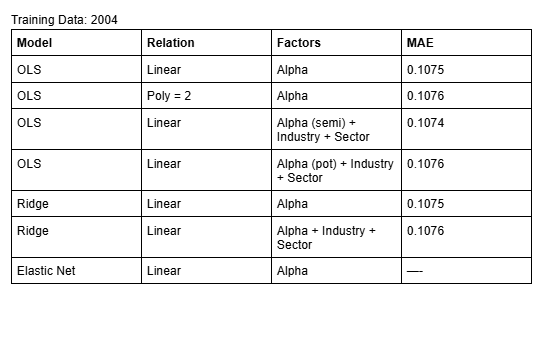

It is evident that the most effective model out of the ones tested is the OLS Linear Regression with Alpha (semi) + Industry + Sector as its factors. Therefore, we continue our analysis with an OLS regression that that excludes the potential alpha factors.

In [53]:
Potential_alphas = ["STREVRSL", "1DREVRSL", "EARNQLTY", "PROFIT"]

In [54]:
test_frames['20050103']

,1DREVRSL,AERODEF,AIRLINES,ALUMSTEL,APPAREL,AUTO,BANKS,BETA,BEVTOB,BIOLIFE,...,SPTYSTOR,STREVRSL,SpecRisk,TELECOM,TRADECO,TRANSPRT,TotalRisk,VALUE,WIRELESS,Yield
0,0.764,0.0,0.0,0.0,0.0,0.0,0.000,-2.310,0.0,0.0,...,0.0,0.087,7.960494,0.054,0.0,0.0,11.145418,0.318,0.0,1.119194
1,0.265,0.0,0.0,0.0,0.0,0.0,0.000,-2.304,0.0,0.0,...,0.0,-1.095,14.676124,0.000,0.0,1.0,19.344810,2.668,0.0,3.035568
2,0.091,0.0,0.0,0.0,0.0,0.0,0.000,-2.497,0.0,0.0,...,0.0,-0.938,24.093288,0.000,0.0,0.0,27.013348,-0.329,0.0,4.729309
3,-2.766,0.0,0.0,0.0,0.0,0.0,0.000,-1.886,0.0,0.0,...,0.0,2.815,28.779869,0.000,0.0,0.0,30.525154,0.981,0.0,2.782609
4,-0.379,0.0,0.0,0.0,0.0,0.0,0.000,-2.167,0.0,0.0,...,0.0,1.325,14.971865,0.000,0.0,0.0,18.202882,2.844,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12412,0.714,0.0,0.0,0.0,0.0,0.0,0.971,-2.058,0.0,0.0,...,0.0,-0.230,9.724343,0.000,0.0,0.0,12.756851,1.129,0.0,2.996575
12413,0.422,0.0,0.0,0.0,0.0,0.0,0.971,-2.247,0.0,0.0,...,0.0,-0.318,9.012007,0.000,0.0,0.0,12.218639,1.129,0.0,7.080000
12414,0.629,0.0,0.0,0.0,0.0,0.0,0.971,-2.118,0.0,0.0,...,0.0,0.152,10.643347,0.000,0.0,0.0,13.455492,1.129,0.0,2.996575
12415,0.470,0.0,0.0,0.0,0.0,0.0,0.971,-2.278,0.0,0.0,...,0.0,0.161,10.187264,0.000,0.0,0.0,13.063631,1.129,0.0,2.996575


In [59]:
for i in range(len(test_frames)):
    test_frames[list(test_frames.keys())[i]] = test_frames[list(test_frames.keys())[i]].drop(["STREVRSL", "1DREVRSL", "EARNQLTY", "PROFIT"],axis=1)

In [60]:
test_frames['20050103']

,AERODEF,AIRLINES,ALUMSTEL,APPAREL,AUTO,BANKS,BETA,BEVTOB,BIOLIFE,BLDGPROD,...,SPTYCHEM,SPTYSTOR,SpecRisk,TELECOM,TRADECO,TRANSPRT,TotalRisk,VALUE,WIRELESS,Yield
0,0.0,0.0,0.0,0.0,0.0,0.000,-2.310,0.0,0.0,0.0,...,0.0,0.0,7.960494,0.054,0.0,0.0,11.145418,0.318,0.0,1.119194
1,0.0,0.0,0.0,0.0,0.0,0.000,-2.304,0.0,0.0,0.0,...,0.0,0.0,14.676124,0.000,0.0,1.0,19.344810,2.668,0.0,3.035568
2,0.0,0.0,0.0,0.0,0.0,0.000,-2.497,0.0,0.0,0.0,...,0.0,0.0,24.093288,0.000,0.0,0.0,27.013348,-0.329,0.0,4.729309
3,0.0,0.0,0.0,0.0,0.0,0.000,-1.886,0.0,0.0,0.0,...,0.0,0.0,28.779869,0.000,0.0,0.0,30.525154,0.981,0.0,2.782609
4,0.0,0.0,0.0,0.0,0.0,0.000,-2.167,0.0,0.0,0.0,...,0.0,0.0,14.971865,0.000,0.0,0.0,18.202882,2.844,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12412,0.0,0.0,0.0,0.0,0.0,0.971,-2.058,0.0,0.0,0.0,...,0.0,0.0,9.724343,0.000,0.0,0.0,12.756851,1.129,0.0,2.996575
12413,0.0,0.0,0.0,0.0,0.0,0.971,-2.247,0.0,0.0,0.0,...,0.0,0.0,9.012007,0.000,0.0,0.0,12.218639,1.129,0.0,7.080000
12414,0.0,0.0,0.0,0.0,0.0,0.971,-2.118,0.0,0.0,0.0,...,0.0,0.0,10.643347,0.000,0.0,0.0,13.455492,1.129,0.0,2.996575
12415,0.0,0.0,0.0,0.0,0.0,0.971,-2.278,0.0,0.0,0.0,...,0.0,0.0,10.187264,0.000,0.0,0.0,13.063631,1.129,0.0,2.996575


In [61]:
Potential_alphas = ["STREVRSL", "EARNQLTY", "PROFIT"]

In [62]:
print(mean_dict)
# remove potential alphas from mean factor returns dictionary
for i in Potential_alphas:
    del mean_dict[i]

{'MGMTQLTY': 3.479344956230722e-05, 'SEASON': 6.766508145261472e-05, 'SENTMT': 8.887079390379914e-05, 'STREVRSL': 0.0003240677336834181, 'EARNQLTY': -2.952057761864898e-05, 'PROFIT': 0.00014679156078909348, 'AERODEF': 0.0008364039411300671, 'AIRLINES': -5.7479795315431605e-05, 'ALUMSTEL': 0.0010829949511445506, 'APPAREL': 0.0009490142220318771, 'AUTO': 3.135908920581122e-06, 'BANKS': 0.0006927373628530731, 'BEVTOB': 0.0007477900287964933, 'BIOLIFE': 0.0002858834029196831, 'BLDGPROD': 0.00044723209617640656, 'CHEM': 0.0011775948222931345, 'CNSTENG': 0.00100429066279409, 'CNSTMACH': 0.0011280126066861714, 'CNSTMATL': 0.0011733269101633255, 'COMMEQP': 1.9612561098231954e-06, 'COMPELEC': 0.00012072871778201336, 'COMSVCS': 0.00029590320481969053, 'CONGLOM': 0.001095831796559359, 'CONTAINR': 0.0010462027615010688, 'DISTRIB': 0.00047311006739893556, 'DIVFIN': 0.0006399421441521586, 'ELECEQP': 0.00012829884859298524, 'ELECUTIL': 0.0006626160497175134, 'FOODPROD': 0.0007442026110796972, 'FOODRE

## Problem 2

In this problem, we will code up a function to compute the Markowitz portfolio for each date in our sample.  

## Loading in Covariance Data

In [63]:
def load_cov(list_year):

    covariance = {}

    for year in list_year:

        file_name = "covariance." + str(year) + ".pickle.bz2"
        fil = os.path.join(model_dir, "", file_name)
        covariance.update(pd.read_pickle( bz2.open(fil, "rb" ) ))

    return covariance

test_year = [2005]
test_cov = load_cov(test_year)

# Comuting the Markowitz Portfolio

The Markowitz Portfolio can be calculated by preforming the dot product of the optimal holdings vector and the returns vector for each data in the sample:

$$h^{*} * r$$

For the returns vector, $r$, we use the column called "Ret" in the same data frame that was used to compute the portfolio itself.

Therefore, $h^{*}$ is given by:

$$h^{*} = (\kappa * \Sigma)^{-1} \mu$$

- For the risk-aversion constant,𝜅, is 1e-5
- Furthermore, we can define $\mu$ as the composite alpha factor from Problem 1 as the substitute for 𝔼[𝐫].

Remember that one can use the Sherman-Morrison-Woodbury Matrix Inversion Lemma to derive a simple expression for the inverse of the covariance matrix in an APT model:

$$(XFX'+D)^{-1}=D^{-1}-D^{-1}X(F^{-1}+X'D^{-1}X)^{-1}X'D^{-1}$$

Additionally, this method is preferred as it to makes code run more efficiently.

In order to calculate the above, we need to compute:
- F: The Diagonal Factor Covariance Matrix
- X: Risk Exposures in array form
- D: Specific Risk Matrix  

Note: We restrict ourself to the estimation universe that was used above in get_estu.

Finally, we plot the cumulative sum of the results.

## Finding X, F, and D Matrix Functions

- The diagnonal_factor_cov function will be helpful in generating the F matrix
- The risk exposures function will be helpful in generating the X matrix

In [64]:
# Define a function to get column names of either a 
# DesginMatrix or a DataFrame
def colnames(X):

    # Check if X is a DesignMatrix object from patsy
    if(type(X) == patsy.design_info.DesignMatrix):
        return(X.design_info.column_names)

    # Check if X is a DataFrame object from pandas
    if(type(X) == pandas.core.frame.DataFrame):
        return(X.columns.tolist())

    # Return None if X is neither a DesignMatrix nor a DataFrame
    return(None)

# F: Diagonal Factor Covariance Matrix for a given date
def diagonal_factor_cov(date, X):

    # Extract the covariance matrix for the given date
    cv = test_cov[date]
    # Get the number of factors (columns) in X
    k = np.shape(X)[1]
    # Initialize an empty matrix to store the diagonal 
    # factor covariance matrix
    Fm = np.zeros([k,k])

    # Iterate over each factor
    for j in range(0,k):

        # Get the name of the j-th factor
        fac = colnames(X)[j]
        # Compute the variance-covariance for the j-th factor
        # and store it in the diagonal of Fm
        Fm[j,j] = (0.01**2) * cv.loc[(cv.Factor1==fac) & (cv.Factor2==fac),"VarCovar"].iloc[0]

    return(Fm)

# X: Risk Exposures for factors
def risk_exposures(estu):
    L = ["0"]
    L.extend(style_factors)
    L.extend(industry_factors)
    # Join the elements of the list wiht " + " to form the formula
    my_formula = " + ".join(L)
    # Return the design matrix based on the formula and the data
    return patsy.dmatrix(my_formula, data = estu)

## Computing the Holdings Vector and Plotting the Cumulative Sum of the Portfolio Returns

Note: When computing the $Σ^{-1}$ using the Sherman-Morrison-Woodbury Matrix Inversion Lemma, since D is a diagonal matrix, we can compute it more efficeintly by creating our own custom function for it.

In [65]:
# Custom Function for Computing the Inverse of a Diagonal Matrix
def diag_inv(D):
    # Check if D is a square matrix
    if D.shape[0] != D.shape[1]:
        raise ValueError("The input matrix must be square.")

    # Check if D is a diagonal matrix
    if not np.all(D == np.diag(np.diagonal(D))):
        raise ValueError("The input matrix must be diagonal.")

    # Check if D contains zero on its diagonal
    if np.any(np.diagonal(D) == 0):
        raise ValueError("The diagonal of the matrix must not contain zero.")

    # Compute the inverse of the diagonal matrix
    D_inv = np.diag(1.0 / np.diagonal(D))

    return D_inv


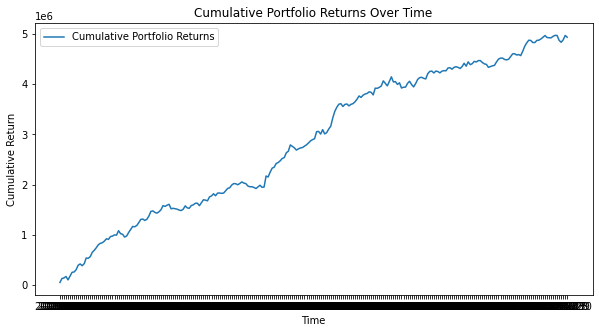

In [66]:
# Define a function to compute the Markowitz Portfolio
# Use k = 1e-5
def compute_markowitz_holdings(frames, covariance, factors, kappa=1e-5):
    portfolio_returns = []
    portfolio_holdings = []

    # Extract dates from frames and sort them
    dates = sorted([date.strftime('%Y%m%d') for date in pd.to_datetime(list(frames.keys()))])

    for date in dates:

        # Get estimation universe and winsorize Data
        estu = get_estu(frames[date])
        estu['Ret'] = wins(estu['Ret'], -0.25, 0.25)

        # Compute risk exposures using the estimation universe
        rske = risk_exposures(estu)

        # Diagonal Factor Covaraince Matrix (F)
        F = diagonal_factor_cov(date, rske)
        # Risk Exposures in array form (X)
        X = np.asarray(rske)
        # Specifc Risk Matrix (D)
        D = np.diag((estu['SpecRisk'] / (100 * math.sqrt(252))) ** 2)

        # Compute the expected returns (using actual factor exposures 
        # and mean factor returns)
        expected_returns = estu[list(factors.keys())].dot(pd.Series(factors))

        # Compute the total risk covariance matrix (X'FX + D)
        total_risk_cov = X @ F @ X.T + D

        # Using the Shermann-Morrison-Woodbury Matrix inversion lemma
        inv_total_risk_cov = diag_inv(D) - diag_inv(D) @ X @ np.linalg.inv(diag_inv(F) + X.T @ diag_inv(D) @ X) @ X.T @ diag_inv(D)

        # Compute the portfolio holdings 
        # using the inverse of the total risk matrix
        holdings = 1/kappa * inv_total_risk_cov @ expected_returns

        portfolio_holdings.append(holdings)

        # Compute portfolio return for the date
        actual_returns = estu['Ret']
        portfolio_return = holdings.T @ actual_returns
        portfolio_returns.append(portfolio_return)

    # Plot the cumulative sum of portfolio returns
    cum_returns = np.cumsum(portfolio_returns)
    plt.figure(figsize=(10, 5))
    plt.plot(dates, cum_returns, label='Cumulative Portfolio Returns')
    plt.xlabel('Time')
    plt.ylabel('Cumulative Return')
    plt.title('Cumulative Portfolio Returns Over Time')
    plt.legend()
    plt.show()

    return portfolio_holdings, cum_returns

portfolio_holdings, cum_returns = compute_markowitz_holdings(test_frames, test_cov, mean_dict, kappa=1e-5)

### Problem 3.

Plot time series of other interesting metrics which help understand the portfolios in problem 2. For example, plot their long/short/net in dollars, number of holdings, factor model's predicted volatility of the portfolio, percent of variance from idio, style, industry. Use the variance decompositions discussed in module 6. Also, predicted beta of the portfolio which is the dot product of holdings with the PredBeta attribute.

- Long Short/ net in dollars
- Number of holdings
- Predicted beta of the portfolio whch is the dot product of the holding with the predbeta attribut

# Examining the Holdings Vector
Now, we examine some of the characteristics of the optimal holdings vector.  
## Number of Holdings

It is important to note that:
- 'Total Number of Positions': This Excludes NaN Values. Therefore, the total number of positions fluctuates over time.



In [67]:
zero_counts = []
zero_value = False
portfolio_holdings_df = pd.DataFrame(portfolio_holdings)
for index, row in portfolio_holdings_df.iterrows():
    zero_count = (row == 0).sum()
    if (zero_count != 0):
        zero_value = True
if (zero_value):
    print("There is a zero value in the data set")
else:
    print("All values in data set are non-zero")

All values in data set are non-zero


In [68]:
nan_counts = []
nan_value = False
for index, row in portfolio_holdings_df.iterrows():
    nan_count = row.isna().sum()
if (nan_count != 0):
    nan_value = True
if (nan_value):
    print("There is at least one nan value in the data set")
else:
    print("There is no nan in the data set")

There is at least one nan value in the data set


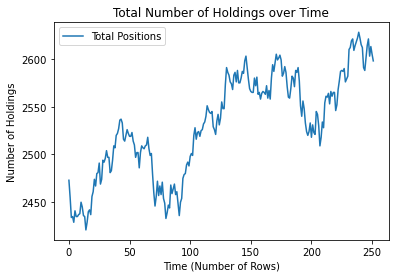

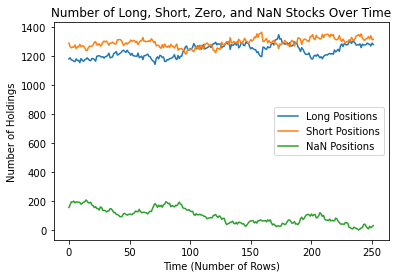

In [69]:
portfolio_holdings_df = pd.DataFrame(portfolio_holdings)
total_holdings = portfolio_holdings_df.sum(axis = 1)


positive_counts = []
negative_counts = []
total_counts = []
nan_counts = []

for index, row in portfolio_holdings_df.iterrows():

    positive_count = (row > 0).sum()  # Count positive values
    negative_count = (row < 0).sum()  # Count negative values
    nan_count = row.isna().sum()  # Count NaN values

    total_count = positive_count + negative_count
    positive_counts.append(positive_count)
    negative_counts.append(negative_count)
    total_counts.append(total_count)
    nan_counts.append(nan_count)

# Total Number Positions
plt.plot(range(len(total_counts)), total_counts, label='Total Positions')
plt.xlabel('Time (Number of Rows)')
plt.ylabel('Number of Holdings')
plt.title('Total Number of Holdings over Time')
plt.legend()
plt.show()

# Plot counts against time
plt.plot(range(len(positive_counts)), positive_counts, label='Long Positions')
plt.plot(range(len(negative_counts)), negative_counts, label='Short Positions')
plt.plot(range(len(nan_counts)), nan_counts, label='NaN Positions')
plt.xlabel('Time (Number of Rows)')
plt.ylabel('Number of Holdings')
plt.title('Number of Long, Short, Zero, and NaN Stocks Over Time')
plt.legend()
plt.show()


## The Amount of Holdings in Dollars
- Long in Dollars
- Short in Dollars
- Total Amount of Holdings in Dollars
- It is the important to note that the 'Long in Dollars' and the 'Short in Dollars' do not add up to the same value throughout time as holdings may change throughout time  

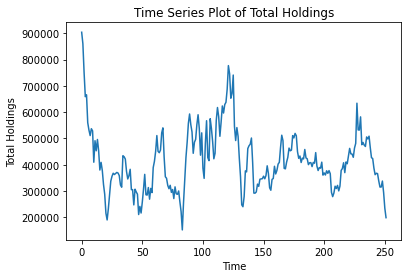

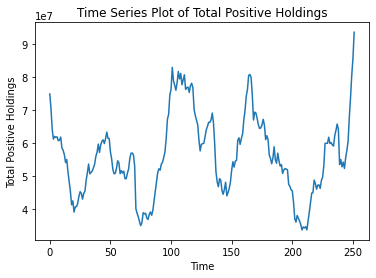

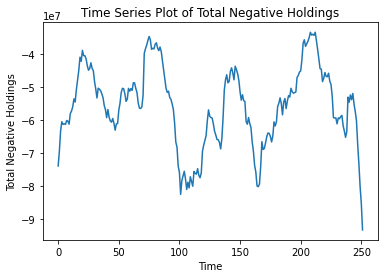

In [70]:
# Amount of Holdings in Dollars

# Create a new list to store the sum of each array
total_portfolio_holdings = [np.sum(array) for array in portfolio_holdings]

# Create a time array (x-axis)
time = np.arange(len(portfolio_holdings))

# Plot the time series
plt.plot(time, total_portfolio_holdings)

# Set the labels and title
plt.xlabel('Time')
plt.ylabel('Total Holdings')
plt.title('Time Series Plot of Total Holdings')

# Show the plot
plt.show()

# Create a new list to store 
# the sum of positive elements in each array
sum_of_longed_holdings = [np.sum(array[array > 0]) for array in portfolio_holdings]

# Create a time array (x-axis)
time = np.arange(len(sum_of_longed_holdings))

# Plot the time series
plt.plot(time, sum_of_longed_holdings)

# Set the labels and title
plt.xlabel('Time')
plt.ylabel('Total Positive Holdings')
plt.title('Time Series Plot of Total Positive Holdings')

# Show the plot
plt.show()

# Create a new list to store 
# the sum of positive elements in each array
sum_of_shorted_holdings = [np.sum(array[array < 0]) for array in portfolio_holdings]

# Create a time array (x-axis)
time = np.arange(len(sum_of_shorted_holdings))

# Plot the time series
plt.plot(time, sum_of_shorted_holdings)

# Set the labels and title
plt.xlabel('Time')
plt.ylabel('Total Negative Holdings')
plt.title('Time Series Plot of Total Negative Holdings')

# Show the plot
plt.show()




## Predicted Beta of the Portfolio

This can be achevied by calculated the dot product of the holdings vector with the PredBeta attribute for each day

In [71]:
pred_betas = []

# For Every Trading Day
for i in range(len(portfolio_holdings)):
    
    # Calculate Estimation Universe
    estu = get_estu(test_frames[list(test_frames.keys())[i]])
    estu['Ret'] = wins(estu['Ret'], -0.25, 0.25)

    arr1 = np.array(list(estu["PredBeta"]))
    arr2 = np.array(list(portfolio_holdings[i]))

    # Take the Dot Product of Portoflio Holdgins
    # And Pred Beta Attribute
    dot_product = np.sum(arr1 * arr2)
    
    pred_betas.append(dot_product)
    

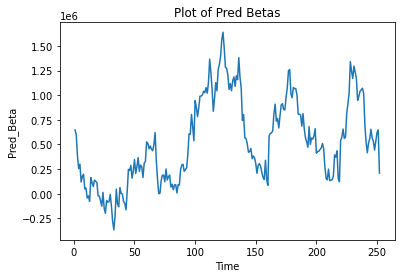

In [72]:
# Plot Pred Betas over Time
plt.plot(np.arange(1,253), pred_betas)
plt.xlabel("Time")
plt.ylabel("Pred_Beta")
plt.title("Plot of Pred Betas")
plt.show()